## Details of LayoutLMv2
- LayoutLMv2 depends on detectron2, torchvision and tesseract

## Getting the data:

In [1]:
import numpy as np
import pandas as pd
import os
import json
import datasets
from datasets import Dataset, DatasetDict, load_dataset, Features, Sequence, ClassLabel, Value, Array2D, Array3D
import json
import re
import random
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
plt.style.use("dark_background")
from typing import Any, List, Tuple

from PIL import Image

In [2]:
# !huggingface-cli login

In [2]:
## Dataset path declaration
path_train = '/home/indra-inc/Datasets/Unstruc/RVL_CDIP_M_600_100/Training/'
path_valid = '/home/indra-inc/Datasets/Unstruc/RVL_CDIP_M_600_100/Valid/'

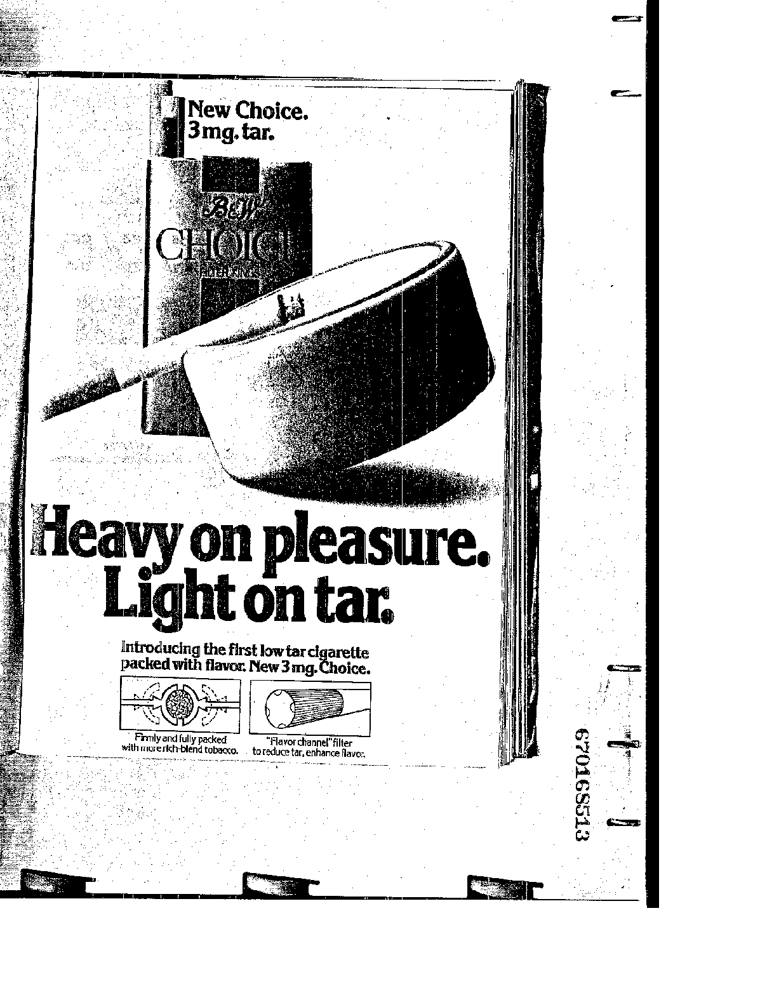

In [3]:
## Reading of any one image
sample_image = Image.open("/home/indra-inc/Datasets/Unstruc/RVL_CDIP_M_600_100/Training/advertisement/0000201420.tif").convert("RGB")
sample_image

In [4]:
checkpoint = "microsoft/layoutlmv2-base-uncased"    # create model checkpoin

In [5]:
## Importing base model of LLMv2
from transformers import LayoutLMv2ImageProcessor, LayoutLMv2TokenizerFast, LayoutLMv2Processor
image_processor = LayoutLMv2ImageProcessor()    ## to apply OCR on the image to get a list of words and normalized bounding boxes
tokenizer = LayoutLMv2TokenizerFast.from_pretrained(checkpoint)    # The words and normalized bounding boxes are then provided which converts them to token-level input_ids, attention_mask, token_type_ids, bbox
processor = LayoutLMv2Processor(image_processor, tokenizer)   # orchestrates the entire pipeline

### Note:
- `LayoutLMv2Processor` uses PyTesseract, a Python wrapper around Google’s Tesseract OCR engine, under the hood. Note that you can still use your own OCR engine of choice, and provide the words and normalized boxes yourself. This requires initializing `LayoutLMv2ImageProcessor` with apply_ocr set to False.
##### Features dictionary will contain the following keys:

- `input_ids`: The input token IDs, which represent the position of each token in the input image.
- `attention_mask`: The attention mask, which specifies which tokens should be attended to and which should be ignored.
- `bbox`: The bounding boxes for each token in the input image, represented as a list of tuples (left, top, right, bottom).
- `token_type_ids` is an optional sequence of integers that represent which part of the input sequence corresponds to the first sentence and which part corresponds to the second sentence, in case of a task that involves two input sentences. For single sentence input, the values are set to 0.
- `image`:
- The `LayoutLMv2Processor` uses optical character recognition (OCR) and object detection techniques to extract text and image features, respectively. During the text recognition process, it also identifies the bounding boxes of the text elements in the image. These bounding boxes are returned as part of the encoded_inputs object, which is a dictionary containing the input tensors required for feeding the data to the LayoutLMv2 model.

## S-1: Analysis of LayoutLMv2 [ImageProcessor, TokenizerFast, Processor]



In [6]:
image_processor

LayoutLMv2ImageProcessor {
  "apply_ocr": true,
  "do_resize": true,
  "image_processor_type": "LayoutLMv2ImageProcessor",
  "ocr_lang": null,
  "resample": 2,
  "size": {
    "height": 224,
    "width": 224
  },
  "tesseract_config": ""
}

In [7]:
type(image_processor)

transformers.models.layoutlmv2.image_processing_layoutlmv2.LayoutLMv2ImageProcessor

In [8]:
# help(image_processor)

In [9]:
print(dir(image_processor))

['__call__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_auto_class', '_create_repo', '_get_files_timestamps', '_processor_class', '_set_processor_class', '_upload_modified_files', 'apply_ocr', 'center_crop', 'do_resize', 'fetch_images', 'from_dict', 'from_json_file', 'from_pretrained', 'get_image_processor_dict', 'model_input_names', 'normalize', 'ocr_lang', 'preprocess', 'push_to_hub', 'register_for_auto_class', 'resample', 'rescale', 'resize', 'save_pretrained', 'size', 'tesseract_config', 'to_dict', 'to_json_file', 'to_json_string']


In [10]:
## Tokenizer class
tokenizer

LayoutLMv2TokenizerFast(name_or_path='microsoft/layoutlmv2-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True)

In [11]:
type(tokenizer)

transformers.models.layoutlmv2.tokenization_layoutlmv2_fast.LayoutLMv2TokenizerFast

In [12]:
## Processor class: combined of image processor and tokenizer
processor

LayoutLMv2Processor:
- image_processor: LayoutLMv2ImageProcessor {
  "apply_ocr": true,
  "do_resize": true,
  "image_processor_type": "LayoutLMv2ImageProcessor",
  "ocr_lang": null,
  "resample": 2,
  "size": {
    "height": 224,
    "width": 224
  },
  "tesseract_config": ""
}

- tokenizer: LayoutLMv2TokenizerFast(name_or_path='microsoft/layoutlmv2-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True)

In [13]:
type(processor)

transformers.models.layoutlmv2.processing_layoutlmv2.LayoutLMv2Processor

In [14]:
encoded_inputs_pt = processor(sample_image, return_tensors="pt")

In [15]:
encoded_inputs_pt

{'input_ids': tensor([[  101,  1064,  3082,  2006, 12203, 28632,  1012,  1064,  1064,  2422,
          2006,  7559,  2009, 14127, 14194,  2075,  1996,  2034,  2659, 16985,
          9907, 13823, 15536,  1060,  2128,  1520,  2047,  1017, 24798,  1012,
          3601,  1012,  1523,  5684,  3149, 29464,  2099,  3802,  4757, 16033,
         24594,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]), 'bbox': tensor([[[   0,    0,    0,    0],
         [   0,  503,    7,  551],
         [  39,  503,  166,  558],
         [ 249,  523,  330,  562],
         [ 385,  461,  635,  583],
         [ 385,  461,  635,  583],
         [ 385,  461,  635,  583],
         [ 660,  488,  706,  569],
         [   5,  570,    9

In [16]:
type(encoded_inputs_pt)

transformers.tokenization_utils_base.BatchEncoding

In [17]:
encoded_inputs_pt.keys()    ## return only keys

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'bbox', 'image'])

In [18]:
# encoded_inputs_pt.items()     ## will return list of tuple contain key value pair

In [19]:
for k,v in encoded_inputs_pt.items():
  # print(k)
  # print(v)
  print(k,":", v.shape)

input_ids : torch.Size([1, 42])
token_type_ids : torch.Size([1, 42])
attention_mask : torch.Size([1, 42])
bbox : torch.Size([1, 42, 4])
image : torch.Size([1, 3, 224, 224])


In [20]:
processor.tokenizer.decode(encoded_inputs_pt.input_ids.squeeze())

'[CLS] | heavy on leasure. | | light ontar itroducing the first low tar cigarette paced wi x re ‘ new 3mg. choice. “ favor channel ier etsssto29 [SEP]'

### Note:
decode() method converts/decodes from one encoding scheme for the argument string to the desired encoding scheme. It is the opposite of the Python encode() method.

decode() accepts the encoding of the encoded string, decodes it, and returns the original string.

In [21]:
# Let's check whether the input_ids are created correctly by decoding them back to text
processor.tokenizer.decode(encoded_inputs_pt.input_ids.squeeze().tolist())

'[CLS] | heavy on leasure. | | light ontar itroducing the first low tar cigarette paced wi x re ‘ new 3mg. choice. “ favor channel ier etsssto29 [SEP]'

#### Note: Explanation:
- The processor.tokenizer refers to the tokenizer used by the LayoutLMv2Processor object.

- encoded_inputs.input_ids is a tensor of shape (1, seq_length) containing the token IDs of the input sequence.

- The squeeze() method removes the dimensions of size 1 from the tensor, so that input_ids becomes a tensor of shape (seq_length,).

- The tolist() method converts the tensor to a Python list.

- Finally, the decode() method of the tokenizer is used to convert the token IDs back into the original text sequence.

- So, the overall code is decoding the input_ids tensor back into the original text sequence using the tokenizer's decode() method.

In [22]:
## Exp-2: direct pass checkpoint on processor and see what will happen
processor_1 = LayoutLMv2Processor.from_pretrained(checkpoint)

In [23]:
processor_1

LayoutLMv2Processor:
- image_processor: LayoutLMv2ImageProcessor {
  "apply_ocr": true,
  "do_resize": true,
  "feature_extractor_type": "LayoutLMv2FeatureExtractor",
  "image_processor_type": "LayoutLMv2ImageProcessor",
  "ocr_lang": null,
  "resample": 2,
  "size": {
    "height": 224,
    "width": 224
  },
  "tesseract_config": ""
}

- tokenizer: LayoutLMv2TokenizerFast(name_or_path='microsoft/layoutlmv2-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True)

In [24]:
processor

LayoutLMv2Processor:
- image_processor: LayoutLMv2ImageProcessor {
  "apply_ocr": true,
  "do_resize": true,
  "image_processor_type": "LayoutLMv2ImageProcessor",
  "ocr_lang": null,
  "resample": 2,
  "size": {
    "height": 224,
    "width": 224
  },
  "tesseract_config": ""
}

- tokenizer: LayoutLMv2TokenizerFast(name_or_path='microsoft/layoutlmv2-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True)

#### Note:
- Both the way we can do the experiment
- Only one difference when we import processor from checkpoint is it includes both `feature_extractor_type`(old) and `image_processor_type`(new)

## S-2: Data Preparation and Processing for LLMv2
- rvl-cdip raw dataset contains 16 class and each class contains 600 images in training data and 100 test data

In [25]:
# Creating sorted label list to maintain parity
# labels_list = sorted([label for label in os.listdir(path_train)])     # pass any path as both train and valid folder contains same named and number of folders
labels_list = [label for label in os.listdir(path_train)]
print(labels_list)
print('**********************************************************')
# label to id dictionary format
label2id_dict = {k: v for v,k in enumerate(labels_list)}     # v is label / class name  k is id i.e. 0,1,2...
print(label2id_dict)
print('**********************************************************')
# id to label dictionary format
id2label_dict = {v: k for v,k in enumerate(labels_list)}     # v is label / class name  k is id i.e. 0,1,2...
print(id2label_dict)

['scientific_report', 'resume', 'memo', 'handwritten', 'letter', 'budget', 'invoice', 'form', 'presentation', 'questionnaire', 'scientific_publication', 'specification', 'email', 'file_folder', 'news_article', 'advertisement']
**********************************************************
{'scientific_report': 0, 'resume': 1, 'memo': 2, 'handwritten': 3, 'letter': 4, 'budget': 5, 'invoice': 6, 'form': 7, 'presentation': 8, 'questionnaire': 9, 'scientific_publication': 10, 'specification': 11, 'email': 12, 'file_folder': 13, 'news_article': 14, 'advertisement': 15}
**********************************************************
{0: 'scientific_report', 1: 'resume', 2: 'memo', 3: 'handwritten', 4: 'letter', 5: 'budget', 6: 'invoice', 7: 'form', 8: 'presentation', 9: 'questionnaire', 10: 'scientific_publication', 11: 'specification', 12: 'email', 13: 'file_folder', 14: 'news_article', 15: 'advertisement'}


In [26]:
len(labels_list)

16

In [28]:
# ## Custom feature creation for Donut Model Execution
# custom_features = Features({
# 'Full_Image_Path': Value(dtype='string', id=None),
# 'Image_label': Value(dtype='string', id=None),
# 'Image_id': ClassLabel(names=labels_list,num_classes=len(labels_list), id=None)
# })

In [29]:
## Creating custom function for whole data preprocessing using label2ids
def dataProcessing(data_folder_path):

  # Initialize empty lists for storing image paths , labels
  images_path_list = []
  images_labels_list = []

  # Iterate throgh all directories and subdirectories and returns list of all the names and path accordingly
  for root, dir_names, files_name in os.walk(data_folder_path):

    ## if base dir is same as root dir then it will continue else not also it will
    if root == data_folder_path:
      continue

    # Extract the label name from the subdirectory path
    label_extracted = os.path.basename(root)

    # Iterate through all the image files in the subdirectory
    for f in files_name:

      # Construct the relative path to the image file
      image_rel_path = os.path.join(root, f)

      # Add the relative image path and label to their respective lists
      images_path_list.append(image_rel_path)
      images_labels_list.append(label_extracted)

  ## Create a Pandas DataFrame
  df = pd.DataFrame({'Full_Image_Path': images_path_list, 'Image_label': images_labels_list})

  # Read dataframe as HuggingFace Dataset object
  dataset_hf = Dataset.from_pandas(df)

  return dataset_hf

In [30]:
hf_train = dataProcessing(path_train)

hf_valid = dataProcessing(path_valid)

In [31]:
hf_train.column_names

['Full_Image_Path', 'Image_label']

In [32]:
hf_valid.column_names

['Full_Image_Path', 'Image_label']

In [33]:
hf_train[5]

{'Full_Image_Path': '/home/indra-inc/Datasets/Unstruc/RVL_CDIP_M_600_100/Training/scientific_report/87519106.tif',
 'Image_label': 'scientific_report'}

In [34]:
## We need to define custom features and dictionary should be same as this
features_custom = Features ({
    'image': Array3D(dtype = 'int64', shape = (3,224,224)),
    'input_ids' : Sequence(feature = Value(dtype = 'int64')),
    'attention_mask': Sequence(Value(dtype = 'int64')),
    'token_type_ids': Sequence(Value(dtype = 'int64')),
    'bbox': Array2D(dtype = 'int64', shape = (512,4)),
    'labels': ClassLabel(num_classes = len(labels_list), names = labels_list)
})

### Note:
- Features class in the Hugging Face Datasets library is used to define the structure and data types of the features in a dataset. It is essentially a container that holds one or more feature definitions, where each feature definition can be one of several classes, such as Sequence, ClassLabel, Value, Array2D, or Array3D.
- Sequence: Represents a sequence of values of a particular data type. For example, it can be used to represent the sequence of token IDs in a text.
- ClassLabel is used to represent categorical labels, and it allows for mapping of class names to class IDs or integers.
- Value is used to represent single values (e.g., a scalar value like an age or a count).
- Array2D is used to represent two-dimensional arrays, such as bounding box coordinates or 2D image features.
- Array3D is used to represent three-dimensional arrays, such as 3D image features or RGB color channels.

In [35]:
# for i in hf_train["Full_Image_Path"]:
#   print(i)

In [36]:
def dataEncoding(hfDataset):
  # to take batch of images
  imgs = [Image.open(path).convert('RGB') for path in hfDataset['Full_Image_Path']]
  encoded_inputs = processor(imgs, padding = 'max_length', truncation = True)

  # add labels** as except labels rest everything we will get from processor
  encoded_inputs['labels'] = [label2id_dict[lbl] for lbl in hfDataset['Image_label']]      # 'labels' name should same as that we define inside feature
  return encoded_inputs

In [37]:
# Now mapping it with whole dataset
hf_train_encoded = hf_train.map(dataEncoding, remove_columns = hf_train.column_names, features=features_custom,
                              batched = True, batch_size = 4)

hf_valid_encoded = hf_valid.map(dataEncoding, remove_columns = hf_valid.column_names, features=features_custom,
                              batched = True, batch_size = 4)

Map:   0%|          | 0/9600 [00:00<?, ? examples/s]

Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

In [38]:
## Convert training and validation processed dataset into Datasetdict
processed_dataset = DatasetDict(
    {
        "train" : hf_train_encoded,
        "valid" : hf_valid_encoded
    }
)

In [39]:
processed_dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'input_ids', 'attention_mask', 'token_type_ids', 'bbox', 'labels'],
        num_rows: 9600
    })
    valid: Dataset({
        features: ['image', 'input_ids', 'attention_mask', 'token_type_ids', 'bbox', 'labels'],
        num_rows: 1600
    })
})

In [40]:
processed_dataset["train"].features

{'image': Array3D(shape=(3, 224, 224), dtype='int64', id=None),
 'input_ids': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None),
 'token_type_ids': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None),
 'bbox': Array2D(shape=(512, 4), dtype='int64', id=None),
 'labels': ClassLabel(names=['scientific_report', 'resume', 'memo', 'handwritten', 'letter', 'budget', 'invoice', 'form', 'presentation', 'questionnaire', 'scientific_publication', 'specification', 'email', 'file_folder', 'news_article', 'advertisement'], id=None)}

## S-3: Uploading the Dataset in Huggingface Hub

In [69]:
# !huggingface-cli login      # for cloab

## when run in local vscode write in cli:   huggingface-cli login --token $YOUR_HUGGINGFACE_TOKEN

In [70]:
# Download train csv format
hf_train_encoded.to_csv("./rvl_cdip_train.csv")

# Download train csv format
hf_valid_encoded.to_csv("./rvl_cdip_valid.csv")

Creating CSV from Arrow format: 100%|██████████| 2/2 [00:05<00:00,  2.64s/ba]


9423286

In [74]:
# Download train json format
hf_train_encoded.to_json("./rvl_cdip_train.json")

# Download train json format
hf_valid_encoded.to_json("./rvl_cdip_valid.json")

Creating json from Arrow format:   0%|          | 0/10 [00:00<?, ?ba/s]

Creating json from Arrow format: 100%|██████████| 2/2 [00:01<00:00,  1.43ba/s]


25376

In [72]:
processed_dataset.save_to_disk("./rvl_cdip_llmv2_processed")

Saving the dataset (4/4 shards): 100%|██████████| 1600/1600 [01:09<00:00, 23.01 examples/s]


In [42]:
# processed_dataset.push_to_hub("indra-inc/rvl_cdip_train600_valid100_llmv2_dc")

In [44]:
## Reload the train and valid dataset dict
processed_dataset_loaded = load_dataset("indra-inc/rvl_cdip_train600_valid100_llmv2_dc")

Resolving data files:   0%|          | 0/26 [00:00<?, ?it/s]

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

In [45]:
processed_dataset_loaded

DatasetDict({
    train: Dataset({
        features: ['image', 'input_ids', 'attention_mask', 'token_type_ids', 'bbox', 'labels'],
        num_rows: 9600
    })
    validation: Dataset({
        features: ['image', 'input_ids', 'attention_mask', 'token_type_ids', 'bbox', 'labels'],
        num_rows: 1600
    })
})

In [50]:
processed_dataset_loaded['train'].features

{'image': Array3D(shape=(3, 224, 224), dtype='int64', id=None),
 'input_ids': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None),
 'token_type_ids': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None),
 'bbox': Array2D(shape=(512, 4), dtype='int64', id=None),
 'labels': ClassLabel(names=['scientific_report', 'resume', 'memo', 'handwritten', 'letter', 'budget', 'invoice', 'form', 'presentation', 'questionnaire', 'scientific_publication', 'specification', 'email', 'file_folder', 'news_article', 'advertisement'], id=None)}

In [49]:
processed_dataset_loaded['validation'].features

{'image': Array3D(shape=(3, 224, 224), dtype='int64', id=None),
 'input_ids': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None),
 'token_type_ids': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None),
 'bbox': Array2D(shape=(512, 4), dtype='int64', id=None),
 'labels': ClassLabel(names=['scientific_report', 'resume', 'memo', 'handwritten', 'letter', 'budget', 'invoice', 'form', 'presentation', 'questionnaire', 'scientific_publication', 'specification', 'email', 'file_folder', 'news_article', 'advertisement'], id=None)}

In [51]:
processed_dataset_loaded['train'].features['labels'].names

['scientific_report',
 'resume',
 'memo',
 'handwritten',
 'letter',
 'budget',
 'invoice',
 'form',
 'presentation',
 'questionnaire',
 'scientific_publication',
 'specification',
 'email',
 'file_folder',
 'news_article',
 'advertisement']

In [52]:
## Isolate the training and validation dataset
train_dataset = processed_dataset_loaded["train"]
valid_dataset = processed_dataset_loaded["validation"]

In [53]:
train_dataset

Dataset({
    features: ['image', 'input_ids', 'attention_mask', 'token_type_ids', 'bbox', 'labels'],
    num_rows: 9600
})

In [54]:
valid_dataset

Dataset({
    features: ['image', 'input_ids', 'attention_mask', 'token_type_ids', 'bbox', 'labels'],
    num_rows: 1600
})

### PyTorch DataLoader Implementation

In [56]:
import torch
from torch.utils.data import DataLoader   # Convert Dataset into PyTorch Dataloader
from transformers import AdamW, LayoutLMv2ForSequenceClassification

In [57]:
# Check if CUDA (GPU support) is available
if torch.cuda.is_available():
    # Get the number of available GPUs
    num_gpus = torch.cuda.device_count()
    
    # Print GPU details
    print(f"Number of available GPUs: {num_gpus}")
    
    for gpu_id in range(num_gpus):
        gpu_name = torch.cuda.get_device_name(gpu_id)
        gpu_memory = torch.cuda.get_device_properties(gpu_id).total_memory / (1024 ** 3)  # Convert to GB
        
        print(f"GPU {gpu_id}: {gpu_name}")
        print(f"GPU Memory: {gpu_memory:.2f} GB")
else:
    print("CUDA (GPU) is not available. Make sure you have a compatible GPU and CUDA installed.")

Number of available GPUs: 1
GPU 0: NVIDIA GeForce GTX 1650
GPU Memory: 3.81 GB


In [59]:
# Encoded_dataset.set_format(type = 'torch', device = 'cuda')
train_dataset.set_format(type = 'torch', device = 'cuda' if torch.cuda.is_available() else 'cpu')
valid_dataset.set_format(type = 'torch', device = 'cuda' if torch.cuda.is_available() else 'cpu')

In [60]:
# to load the encoded dataset in batches during the training and validation process
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)    # Shuffling dataset for Model Training
valid_dataloader = DataLoader(valid_dataset, batch_size=4)

In [61]:
batch_train = next(iter(train_dataloader))      # retrieves the data batchwise

In [62]:
batch_train

{'image': tensor([[[[  1,   9,  13,  ..., 233, 255, 255],
           [ 23,  86,  85,  ..., 239, 255, 255],
           [ 36, 122, 122,  ..., 254, 255, 255],
           ...,
           [ 74, 235, 255,  ..., 255, 255, 255],
           [ 73, 234, 255,  ..., 255, 255, 255],
           [ 73, 234, 255,  ..., 255, 255, 255]],
 
          [[  1,   9,  13,  ..., 233, 255, 255],
           [ 23,  86,  85,  ..., 239, 255, 255],
           [ 36, 122, 122,  ..., 254, 255, 255],
           ...,
           [ 74, 235, 255,  ..., 255, 255, 255],
           [ 73, 234, 255,  ..., 255, 255, 255],
           [ 73, 234, 255,  ..., 255, 255, 255]],
 
          [[  1,   9,  13,  ..., 233, 255, 255],
           [ 23,  86,  85,  ..., 239, 255, 255],
           [ 36, 122, 122,  ..., 254, 255, 255],
           ...,
           [ 74, 235, 255,  ..., 255, 255, 255],
           [ 73, 234, 255,  ..., 255, 255, 255],
           [ 73, 234, 255,  ..., 255, 255, 255]]],
 
 
         [[[238, 239, 252,  ..., 255, 255, 255],


In [63]:
batch_train.keys()

dict_keys(['image', 'input_ids', 'attention_mask', 'token_type_ids', 'bbox', 'labels'])

In [67]:
type(batch_train)

dict

In [69]:
for k,v in batch_train.items():
  print(k,"||||", v.shape)

image |||| torch.Size([4, 3, 224, 224])
input_ids |||| torch.Size([4, 512])
attention_mask |||| torch.Size([4, 512])
token_type_ids |||| torch.Size([4, 512])
bbox |||| torch.Size([4, 512, 4])
labels |||| torch.Size([4])


In [70]:
type(batch_train['input_ids'][0])

torch.Tensor

In [71]:
type(batch_train['input_ids'][0].tolist())

list

In [76]:
## Sample decode check
processor.tokenizer.decode(batch_train['input_ids'][0].tolist())

'[CLS] me. jack seelhorat 104 ketler hall grove city college grove city, pennsylvania dear mr. seelhorst : cc we feel sure that they will be able to provide you with the information you need to come plete your paper. sincerely, broest \\ p. j assietine to director of public relations. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] 

In [77]:
train_dataloader

In [78]:
valid_dataloader

### Comments: dataloader.dataset
- 'features' attribute represents the different fields or columns that the dataset contains i.e. in short provides a description of the dataset's schema or structure
      - features: ['image', 'input_ids', 'attention_mask', 'token_type_ids', 'bbox', 'labels']
      - image is the input image for the document classification task
      - input_ids, attention_mask, and token_type_ids are the encoded inputs of the text in the image.
      - bbox contains the bounding boxes of the tokens in the image.
      - labels contains the labels/targets of the classification task.
- 'num_rows' is the number of rows or examples in the dataset

### Note: DataLoader:

- The DataLoader is used to load the encoded dataset in batches during the training process. It helps to efficiently load the data in memory in a way that minimizes the CPU and memory usage, particularly when dealing with large datasets.

- Using a dataloader, we can specify the batch size, which defines how many samples to be included in a single batch. During training, the model is updated based on the gradients computed on the current batch of data, and the weights are updated after each batch. By iterating over the dataloader, we can obtain multiple batches of data to train the model.

- The next(iter(dataloader)) line of code retrieves the first batch of data from the dataloader, which can be passed to the model for training. The next() function is used to get the next element from the dataloader iterator, and the iter() function is used to create an iterator object that can be used to iterate over the batches in the dataloader.

### Q. How much DataLoader is important?
Ans: When working with large datasets, it is generally recommended to use dataloaders in PyTorch for efficient loading and processing of data in batches. Dataloaders allow us to load the data in small batches and perform operations on them in parallel on the GPU, which makes the training process faster and more memory-efficient.

Even for smaller datasets, it is still beneficial to use dataloaders because they provide a convenient way to handle the data during training, validation, and testing. The dataloader will automatically shuffle the data, split it into batches, and load it onto the GPU.

Therefore, it is recommended to use dataloaders when working with PyTorch, especially when dealing with large datasets.

### Q. At the time of using CPU, Dataloader is also important?
Ans: Using a DataLoader is not strictly necessary when using PyTorch on CPU, but it can still be helpful in certain situations. For example, if your dataset is very large and cannot fit entirely in memory, you may need to use a DataLoader to load and process the data in batches. Additionally, using a DataLoader can help simplify your code and make it easier to iterate over the data in a standardized way, regardless of whether you're using a CPU or GPU.

## Define & create the Model:
Here we define the model, namely LayoutLMv2ForSequenceClassification. We initialize it with the weights of the pre-trained base model (LayoutLMModel). The weights of the classification head are randomly initialized, and will be fine-tuned together with the weights of the base model on our tiny dataset. Once loaded, we move it to the GPU.

In [79]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'   # setup device

## define model
model = LayoutLMv2ForSequenceClassification.from_pretrained(checkpoint,
                                                  num_labels=len(labels_list))  # this labels should be label list from the dataframe i.e. all the target column list

## Move model into cuda device
model.to(device)

Some weights of LayoutLMv2ForSequenceClassification were not initialized from the model checkpoint at microsoft/layoutlmv2-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


LayoutLMv2ForSequenceClassification(
  (layoutlmv2): LayoutLMv2Model(
    (embeddings): LayoutLMv2Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (x_position_embeddings): Embedding(1024, 128)
      (y_position_embeddings): Embedding(1024, 128)
      (h_position_embeddings): Embedding(1024, 128)
      (w_position_embeddings): Embedding(1024, 128)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (visual): LayoutLMv2VisualBackbone(
      (backbone): FPN(
        (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
        (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
        (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

####  Notes: -q

- pip package installer to install the transformers package from the GitHub repository of Hugging Face.
- -q flag is used to suppress the output during installation.
- -q flag is a short form of the --quiet flag, which is used to suppress the output of the command being executed. When you run a command with the -q flag, it will only display error messages and warnings, if any. This can be useful if you don't want to see the detailed output of the command and only want to know if it succeeded or failed.

- In the case of installing packages using pip, using the -q flag will prevent the installation process from printing all the details of the packages that are being installed. This can be useful when you're installing a lot of packages and don't want your terminal to be flooded with installation messages. Instead, you'll only see the error messages and warnings, which can help you identify any issues that arise during installation.

- This code installs the required dependencies for the detectron2 package, which is a deep learning library for object detection and segmentation. Here's a breakdown of what each line does:

- !pip install -q pyyaml==5.1: This installs the PyYAML package with version 5.1. PyYAML is a YAML parser and emitter for Python, and it's used by detectron2 for configuration files.

- !pip install -q torch==1.8.0+cu101 torchvision==0.9.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html: This installs an old version of PyTorch (1.8.0) and its corresponding torchvision package (0.9.0) that matches the CUDA version (cu101) used by the system. This is a workaround because detectron2 hasn't released packages for PyTorch 1.9 yet, and the PyTorch 1.8.0 version is required to run detectron2.

- !python -m pip install -q 'git+https://github.com/facebookresearch/detectron2.git': This installs the detectron2 package from the GitHub repository of Facebook Research. The package is installed using pip, and the -q flag is used to suppress the output during installation. This is the main package that is required for running detectron2.

- Note: The third step has two different ways to install detectron2, and both are commented. The user can choose either of the ways depending on their system's compatibility.

- 'datasets' has some special properties that set it apart from other Python libraries for working with datasets. Here are some of the key features of datasets:

- Easy-to-use API: datasets provides a simple and intuitive API for loading and processing datasets. This makes it easy for researchers and developers to get started with NLP tasks without having to spend a lot of time on data preprocessing.

- Large collection of datasets: datasets provides access to a large collection of datasets for NLP tasks, including popular datasets like GLUE, SuperGLUE, and SQuAD. This makes it easy to experiment with different datasets and tasks without having to find and preprocess the data yourself.

- High-quality data: The datasets available in datasets are curated and preprocessed to ensure high quality. This helps to ensure that the data is suitable for use in research and production systems.

- Integration with PyTorch and TensorFlow: datasets provides integration with popular deep learning frameworks like PyTorch and TensorFlow. This makes it easy to use the datasets in your machine learning pipelines.

- Custom dataset creation: datasets also provides tools for creating custom datasets from various sources, including CSV files, JSON files, and web APIs. This makes it easy to work with your own data or data from other sources.

- Overall, datasets provides a powerful and flexible platform for working with NLP datasets, making it an essential tool for NLP researchers and developers.

- import requests, zipfile, io: This line imports the requests, zipfile, and io modules. These modules provide functionality for downloading data from the web and working with zip files.

- def download_data():: This line defines the function download_data(), which will download and extract the dataset.

- url = "https://www.dropbox.com/s/kuw05qmc4uy474d/RVL_CDIP_one_example_per_class.zip?dl=1": This line sets the URL of the zip file to be downloaded. In this case, the file is hosted on Dropbox and can be downloaded by adding ?dl=1 to the end of the URL.

- r = requests.get(url): This line uses the requests module to download the contents of the zip file from the URL.

- z = zipfile.ZipFile(io.BytesIO(r.content)): This line uses the zipfile and io modules to extract the contents of the downloaded zip file. io.BytesIO() creates a binary stream of the content returned by the requests module, which can be read by zipfile.ZipFile().

- z.extractall(): This line extracts all the files in the zip archive to the current working directory.

- download_data(): This line calls the download_data() function, which initiates the download and extraction of the dataset.